# **Image Classification**
Image classification is the task of assigning a label or class to an image. There are many applications for image classification, such as detecting damage after a natural disaster, monitoring crop health, or helping screen medical images for signs of disease.

We shall fine-tune a ViT model using TensorFlow on Food-101 dataset to classify a food item in an image.

### **1. Install and Import Required Libraries**

In [ ]:
!pip install datasets transformers evaluate

In [ ]:
import numpy as np
import tensorflow as tf
import collections
import evaluate

from transformers import AutoImageProcessor, DefaultDataCollator, TFAutoModelForImageClassification, create_optimizer, pipeline
from transformers.keras_callbacks import KerasMetricCallback
from datasets import load_dataset, Dataset

### **2. Load Data**

In [ ]:
raw_dataset = load_dataset('food101', streaming=True)

In [ ]:
num_samples = 1000
train_iterable_dataset = raw_dataset['train'].take(num_samples)
validation_iterable_dataset = raw_dataset['train'].skip(num_samples).take(int(num_samples/10))

train_data = collections.defaultdict(list)
validation_data = collections.defaultdict(list)

for example in train_iterable_dataset:
  for key in example.keys():
    train_data[key].append(example[key])

train_dataset = Dataset.from_dict(
    train_data,
    features=train_iterable_dataset.features,
    info=train_iterable_dataset.info,
    split='train'
)

for example in validation_iterable_dataset:
  for key in example.keys():
    validation_data[key].append(example[key])

validation_dataset = Dataset.from_dict(
    validation_data,
    features=validation_iterable_dataset.features,
    info=validation_iterable_dataset.info,
    split='validation'
)

### **3. Preprocess Data**

In [ ]:
model_checkpoint = 'google/vit-base-patch16-224-in21k'
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

In [ ]:
img_height, img_width = image_processor.size['height'], image_processor.size['width']

print(f"img_height: {img_height}")
print(f"img_width: {img_width}")

img_height: 224
img_width: 224


In [ ]:
train_data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomCrop(height=img_height, width=img_width),
        tf.keras.layers.Rescaling(scale=1.0/127.5, offset=-1),
        tf.keras.layers.RandomFlip(mode='horizontal'),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2)
    ],
    name='train_data_augmentation'
)

validation_data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.CenterCrop(height=img_height, width=img_width),
        tf.keras.layers.Rescaling(scale=1.0/127.5, offset=-1)
    ],
    name='validation_data_augmentation'
)

In [ ]:
def convert_to_tf_tensor(image):
  np_image = np.array(image)
  tf_image = tf.convert_to_tensor(np_image)
  # Adding batch dimension using expand_dims since TensorFlow augmentation layers operate on batched inputs
  return tf.expand_dims(tf_image, 0)

def preprocess_train(example_batch):
  images = [train_data_augmentation(convert_to_tf_tensor(image.convert('RGB'))) for image in example_batch['image']]
  # Computer vision models in Hugging Face transformers library expect images in channels-first layout
  # Changing image shape from (1, 224, 224, 3) to (3, 224, 224) using tf.squeeze and tf.transpose
  example_batch['pixel_values'] = [tf.transpose(tf.squeeze(image)) for image in images]
  return example_batch

def preprocess_validation(example_batch):
  images = [validation_data_augmentation(convert_to_tf_tensor(image.convert('RGB'))) for image in example_batch['image']]
  # Computer vision models in Hugging Face transformers library expect images in channels-first layout
  # Changing image shape from (1, 224, 224, 3) to (3, 224, 224) using tf.squeeze and tf.transpose
  example_batch['pixel_values'] = [tf.transpose(tf.squeeze(image)) for image in images]
  return example_batch

# Applying preprocessing transformations on the fly using set_transform
train_dataset.set_transform(preprocess_train)
validation_dataset.set_transform(preprocess_validation)

print(f"train_dataset keys:\n{train_dataset[0].keys()}")
print(f"validation_dataset keys:\n{validation_dataset[0].keys()}")

train_dataset keys:
dict_keys(['image', 'label', 'pixel_values'])
validation_dataset keys:
dict_keys(['image', 'label', 'pixel_values'])


In [ ]:
batch_size = 16
data_collator = DefaultDataCollator(return_tensors='tf')

tf_train_dataset = train_dataset.to_tf_dataset(
    columns='pixel_values',
    label_cols='label',
    collate_fn=data_collator,
    shuffle=True,
    batch_size=batch_size
)

tf_validation_dataset = validation_dataset.to_tf_dataset(
    columns='pixel_values',
    label_cols='label',
    collate_fn=data_collator,
    shuffle=True,
    batch_size=batch_size
)

### **4. Fine-tune the Model**

In [ ]:
labels = train_dataset.features['label'].names

label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
  label2id[label] = i
  id2label[i] = label

In [ ]:
model = TFAutoModelForImageClassification.from_pretrained(model_checkpoint, id2label=id2label, label2id=label2id)

In [ ]:
num_epochs = 5
num_train_steps = len(tf_train_dataset) * num_epochs

optimizer, schedule = create_optimizer(init_lr=3e-5, num_train_steps=num_train_steps, num_warmup_steps=0, weight_decay_rate=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss)

In [ ]:
metric = evaluate.load('accuracy')

def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return metric.compute(predictions=predictions, references=labels)

In [ ]:
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_dataset)

In [ ]:
history = model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=num_epochs, callbacks=[metric_callback], verbose=1)

Epoch 1/5
63/63 [==============================] - 112s 1s/step - loss: 3.1592 - val_loss: 2.9327 - accuracy: 0.5500
Epoch 2/5
63/63 [==============================] - 81s 1s/step - loss: 1.8548 - val_loss: 2.1309 - accuracy: 0.8800
Epoch 3/5
63/63 [==============================] - 80s 1s/step - loss: 1.4508 - val_loss: 1.6299 - accuracy: 0.9800
Epoch 4/5
63/63 [==============================] - 80s 1s/step - loss: 1.2473 - val_loss: 1.4851 - accuracy: 0.9800
Epoch 5/5
63/63 [==============================] - 80s 1s/step - loss: 1.1613 - val_loss: 1.4507 - accuracy: 0.9800


### **5. Predict using the Fine-tuned Model**

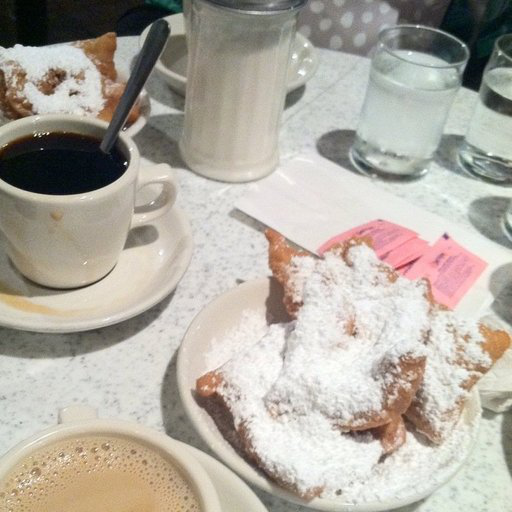

In [ ]:
test_data = raw_dataset['validation'].take(1)
test_image = next(iter(test_data))['image']
test_image

In [ ]:
# Predicting using pipeline
image_classifier = pipeline('image-classification', model=model, image_processor=image_processor)
image_classifier(test_image)

[{'score': 0.34840127825737, 'label': 'beignets'},
 {'score': 0.02254532091319561, 'label': 'prime_rib'},
 {'score': 0.00804443284869194, 'label': 'lobster_bisque'},
 {'score': 0.007874882780015469, 'label': 'creme_brulee'},
 {'score': 0.0076988167129457, 'label': 'samosa'}]

In [ ]:
# Predicting using manual approach
inputs = image_processor(test_image, return_tensors='tf')
logits = model(**inputs)['logits']

predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
model.config.id2label[predicted_class_id]

'beignets'